In [1]:
import sys
sys.path.append("..")

In [2]:
from data_tools.tools import *

In [3]:
path_to_results = "../data/results/DE_3_2"

results = load_feather_folder_as_pd(path_to_results)

0.014981746673583984


In [4]:
#sort results by mse
results = results.sort_values(by="mse")

#add a column gamma np.sqrt(0.5*1/sigma)
results["gamma"] = np.sqrt(0.5*1/results["sigma"])

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
results.head()


,f_PQK,optimal_alpha_PQK,sigma,mse,CI_encoding_circuit_label,CI_num_qubits,CI_num_layers,gamma
188,"[0.7462484448312807, 0.37070915358503953, 0.09...","[527.2035566108441, 11654.044193532463, -2254....",2.182051,0.169496,HardwareEfficientEmbeddingCircuit_qiskit,3,2,0.478688
1223,"[0.6813222134541235, 0.36283248933513335, 0.11...","[32.47389927363828, 10700.996966184091, 2340.3...",1.810256,0.171762,Separable_rx_qiskit,2,1,0.525551
50,"[0.7218739412507915, 0.37181751263254625, 0.10...","[49.68023671892409, 7479.356484869572, 1673.20...",0.843590,0.172405,HardwareEfficientEmbeddingCircuit_qiskit,2,2,0.769873
1351,"[0.7682763931903978, 0.4118604861781918, 0.139...","[53.42855552802816, 4865.596167624351, 1100.14...",2.405128,0.172907,Separable_rx_qiskit,3,1,0.455949
96,"[0.5581359192619857, 0.20649437594602205, -0.0...","[288.9700724767281, 6566.974817390657, 590.877...",1.289744,0.173962,HardwareEfficientEmbeddingCircuit_qiskit,2,3,0.622635


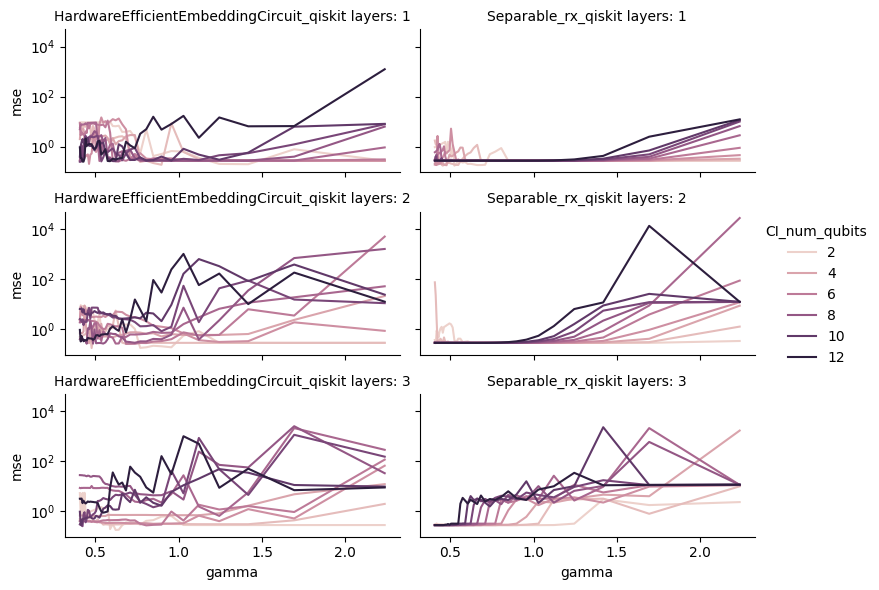

In [7]:
#log scale 

g = sns.relplot(x="gamma", y="mse", 
                data=results, 
                kind="line", 
                col="CI_encoding_circuit_label", 
                hue="CI_num_qubits", 
                row="CI_num_layers", 
                height=2,  # Adjust the height as needed
                aspect=2  
                )

#set titles
g.set_titles("{col_name} layers: {row_name}")
g.set(yscale="log")

In [8]:
def f_analytical_fun(x):
    """Analytical solution of the ODE from the paper

    """
    lamb  = 20
    k = 0.1
    return np.exp(-lamb*x*k)*np.cos(lamb*x)

In [9]:
results = results.sort_values(by="mse")

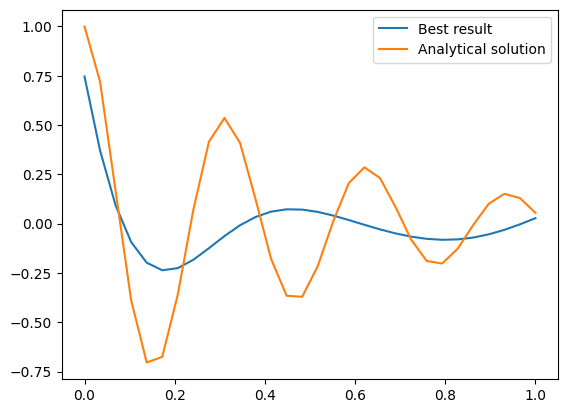

In [10]:
#result with lowest mse
x_span = np.linspace(0, 1, 30)
plt.plot(x_span, results.iloc[0]["f_PQK"], label="Best result")
plt.plot(x_span, f_analytical_fun(x_span), label="Analytical solution")
plt.legend()

In [24]:
def g(f, x):
        lamb = 20
        k = 0.1
        return -lamb * np.exp(-lamb * x * k) * np.sin(lamb * x) - lamb * k * f

In [28]:
from circuits.circuits import * 
from utils.rbf_kernel_tools import *

from solvers.MMR.PQK_solver import PQK_solver
from solvers.MMR.FQK_solver import FQK_solver
from solvers.MMR.kernel_solver import Solver

x_span = np.linspace(0, 1, 30)

def get_K_from_row(row, method, executor_type):
    """Get the K matrix from a row in the results dataframe
    """
    print(row["CI_encoding_circuit_label"])
    circuit_information = {"num_qubits": row["CI_num_qubits"],
                            "num_layers": row["CI_num_layers"],
                            "encoding_circuit": circuits_dictionary_qiskit[row["CI_encoding_circuit_label"]]
                            }
    print(circuit_information)
    if method == "PQK":
        O_Solver = PQK_solver(circuit_information, executor_type, envelope={"function": rbf_kernel_manual, 
                                            "derivative_function": analytical_derivative_rbf_kernel, 
                                            "sigma": row["sigma"]})
    elif method == "FQK":
        O_Solver = FQK_solver(circuit_information, executor_type)
    elif method == "classical_RBF":
        O_Solver = Solver(circuit_information)

    
    
    return O_Solver.get_Kernel(x_span)

In [29]:
best_K_PQK = get_K_from_row(results.iloc[0], "PQK", Executor("statevector_simulator"))

HardwareEfficientEmbeddingCircuit_qiskit
{'num_qubits': 3, 'num_layers': 2, 'encoding_circuit': <function HardwareEfficientEmbeddingCircuit_qiskit at 0x0000020A1DF0ACB0>}


In [32]:
best_K_classical_RBF = rbf_kernel_manual(x_span, x_span, sigma = 0.2)


RBF_kernel_list = [rbf_kernel_manual(x_span, x_span, sigma = 0.2), analytical_derivative_rbf_kernel(x_span, x_span, sigma = 0.2)]
Solver_test = Solver(RBF_kernel_list)

f_RBF, optimal_alpha_RBF = Solver_test.solve(x_span, 1, g)

Initial loss:  34589.47186320814
         Current function value: 0.202558
         Iterations: 74
         Function evaluations: 3980
         Gradient evaluations: 124


In [33]:
def eigendecomposition(K):
    """Returns ordered eigenvalues and normalized eigenvectors of a kernel matrix."""
    eigenvalue_spectrum, eigenvectors = np.linalg.eigh(1/K.shape[0] * K)
    inds_sort = np.argsort(eigenvalue_spectrum)
    inds_sort = inds_sort[::-1]
    eigenvalue_spectrum = eigenvalue_spectrum[inds_sort]
    eigenvectors = eigenvectors[:,inds_sort]
    return eigenvalue_spectrum, eigenvectors

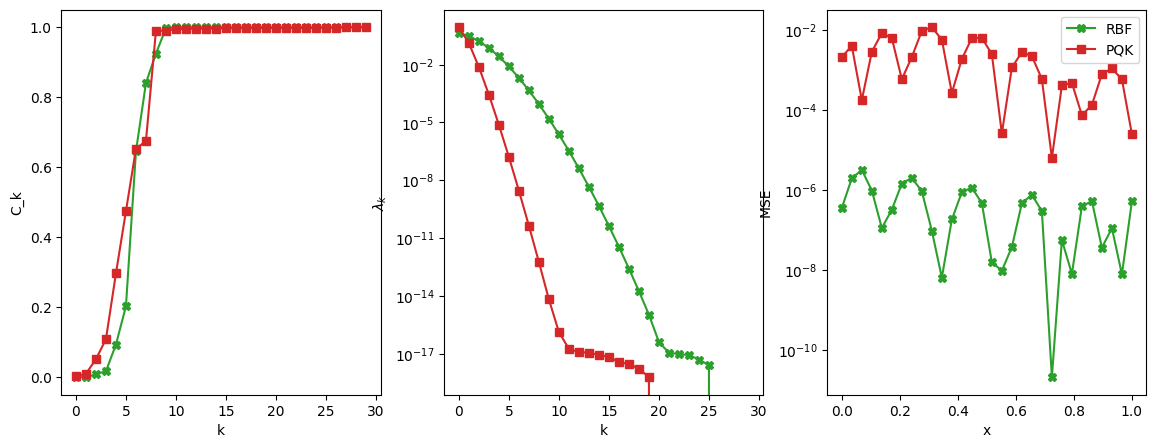

In [40]:
kernel_tensor = [best_K_classical_RBF, best_K_PQK]
solution_list = [f_RBF, results.iloc[0]["f_PQK"]]
marker = ["X-", "s-", "o-"]
x_span = np.linspace(0, 1, 30)

labels = ["RBF", "PQK"]

#two column plot axes
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
for idx_kernel, kernels in enumerate(kernel_tensor):
    K_f = kernels
    eigenvalue_spectrum, eigenvectors = eigendecomposition(K_f)    

    y_train_for_analytical = f_analytical_fun(x_span)
    if len(y_train_for_analytical.shape) == 1:
        y_train_for_analytical = y_train_for_analytical.reshape(-1, 1)

    #y_train is a column vector
    power = np.sum((eigenvectors.T @ y_train_for_analytical)**2, axis = 1)
    cumul = np.cumsum(power) / np.sum(power)


    axs[0].plot(cumul,marker[idx_kernel], label = f"{labels[idx_kernel]}", color = f"C{idx_kernel+2}")
    axs[0].set_ylabel("C_k")
    axs[0].set_xlabel("k")
    

    axs[1].plot(eigenvalue_spectrum, marker[idx_kernel], label = f"{labels[idx_kernel]}", color = f"C{idx_kernel+2}")
    axs[1].set_ylabel("$\lambda_k$")
    axs[1].set_xlabel("k")
    axs[1].set_yscale("log")    


    #mean squared error as a function of x

    mse = (solution_list[idx_kernel] - f_analytical_fun(x_span))**2/ len(x_span)

    axs[2].plot(x_span, mse, marker[idx_kernel], label = f"{labels[idx_kernel]}", color = f"C{idx_kernel+2}")
    axs[2].set_ylabel("MSE")
    axs[2].set_yscale("log")
    axs[2].set_xlabel("x")




    


plt.legend()
